In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Datasets.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mydataset')

In [3]:
import numpy as np 
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as colormap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


In [4]:
train_dir = '/content/mydataset/Datasets-6/FER2013/train/'
val_dir = '/content/mydataset/Datasets-6/FER2013/validation/'
test_dir ='/content/mydataset/Datasets-6/FER2013/test/'

train_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
val_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(val_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
test_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_dir) for f in filenames if f.endswith(('.jpg', '.png'))]

print('train_images:',len(train_images))
print('val_images:',len(val_images))
print('test_images:',len(test_images))


train_images: 3208
val_images: 809
test_images: 1020


In [5]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224, 224))
    ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))
    ])

class dataset(Dataset):
    def __init__(self, images_dir, transform, device):
        self.images_dir = images_dir
        self.transform = transform
        self.device = device
        self.class_names = sorted(os.listdir(self.images_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.device = device
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        image = self.transform(image).to(self.device)
        label = torch.LongTensor([label]).to(self.device)
        return image, label

In [6]:

from PIL import Image

root_dir = "/content/mydataset/Datasets-6/FER2013"

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)
        if os.path.isfile(img_path):
            if os.path.getsize(img_path) > 0:
                try:
                    img = Image.open(img_path)
                    img.verify()
                except (IOError, SyntaxError) as e:
                    print('Invalid image: {}'.format(img_path))
                    os.remove(img_path)
            else:
                print('Zero length file: {}'.format(img_path))
                os.remove(img_path)



Invalid image: /content/mydataset/Datasets-6/FER2013/.DS_Store
Invalid image: /content/mydataset/Datasets-6/FER2013/train/.DS_Store
Invalid image: /content/mydataset/Datasets-6/FER2013/train/neutral/.DS_Store
Invalid image: /content/mydataset/Datasets-6/FER2013/train/surprise/.DS_Store
Invalid image: /content/mydataset/Datasets-6/FER2013/validation/.DS_Store
Invalid image: /content/mydataset/Datasets-6/FER2013/validation/happy/.DS_Store
Invalid image: /content/mydataset/Datasets-6/FER2013/test/.DS_Store


In [7]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
torch.cuda.empty_cache()

train_data = dataset(train_dir, train_transforms, device)
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)

val_data = dataset(val_dir, train_transforms, device)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = True)

test_data = dataset(test_dir, test_transforms, device)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

In [8]:
def plot_data_loader(data_loader, gridDims, class_names):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, labels = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
            axes[i, j].set_title(class_names[labels[0]])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

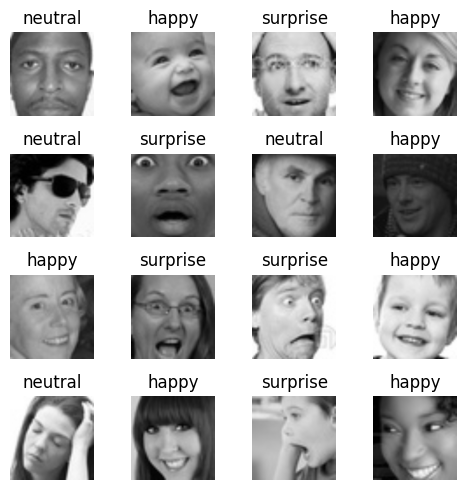

In [9]:
plot_data_loader(train_loader, (4, 4), train_data.class_names)

In [10]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        labels = labels.reshape(-1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [11]:
def val_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc

In [12]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_labelsForProbs = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labelsForProbs.append(labels.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds += preds.cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()
    all_probs = np.concatenate(all_probs)
    all_labelsForProbs = np.concatenate(all_labelsForProbs)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_classification_report = classification_report(all_labels, all_preds)
    print(f'Test Results:')
    print(f'Test Accuracy: {epoch_acc:.4f}')
    print(f'\n{epoch_classification_report}')
    cm = confusion_matrix(all_labels, all_preds)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=train_data.class_names, yticklabels=test_data.class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    n_classes = len(test_data.class_names)
    y_test = label_binarize(all_labelsForProbs, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], all_probs[:, i], average='macro')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), all_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, all_probs, average="micro")
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    label_names = test_data.class_names
    cmap = colormap.get_cmap('tab20',len(label_names))
    colors = [cmap(i) for i in range(len(label_names))]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'shufflenet_v2_x1_0', pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_data.class_names))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)
print("Device: {}".format(device))

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip


Device: cuda


In [14]:
num_epochs = 25
patience = 7
best_acc = 0  
best_model = None

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = val_model(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
  
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0  
        best_model = model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 1/25 | Train Loss: 1.0713 | Train Acc: 0.4264 | Val Loss: 1.6396 | Val Acc: 0.3337


100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 2/25 | Train Loss: 1.0437 | Train Acc: 0.4526 | Val Loss: 1.1711 | Val Acc: 0.3337


100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Epoch 3/25 | Train Loss: 1.0201 | Train Acc: 0.4794 | Val Loss: 0.9138 | Val Acc: 0.4277


100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Epoch 4/25 | Train Loss: 0.9333 | Train Acc: 0.5611 | Val Loss: 0.8625 | Val Acc: 0.5019


100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch 5/25 | Train Loss: 0.8672 | Train Acc: 0.6113 | Val Loss: 0.7399 | Val Acc: 0.5686


100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Epoch 6/25 | Train Loss: 0.7868 | Train Acc: 0.6549 | Val Loss: 0.6799 | Val Acc: 0.6020


100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch 7/25 | Train Loss: 0.7009 | Train Acc: 0.6986 | Val Loss: 0.7727 | Val Acc: 0.5983


100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


Epoch 8/25 | Train Loss: 0.6633 | Train Acc: 0.7210 | Val Loss: 0.7177 | Val Acc: 0.6242


100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch 9/25 | Train Loss: 0.5718 | Train Acc: 0.7684 | Val Loss: 0.7047 | Val Acc: 0.6564


100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 10/25 | Train Loss: 0.5208 | Train Acc: 0.7865 | Val Loss: 0.6767 | Val Acc: 0.6675


100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 11/25 | Train Loss: 0.4915 | Train Acc: 0.8117 | Val Loss: 0.6987 | Val Acc: 0.6527


100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 12/25 | Train Loss: 0.5048 | Train Acc: 0.7946 | Val Loss: 0.6707 | Val Acc: 0.6700


100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 13/25 | Train Loss: 0.4544 | Train Acc: 0.8136 | Val Loss: 0.6693 | Val Acc: 0.6910


100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 14/25 | Train Loss: 0.4226 | Train Acc: 0.8420 | Val Loss: 0.6576 | Val Acc: 0.7033


100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch 15/25 | Train Loss: 0.3340 | Train Acc: 0.8675 | Val Loss: 0.6761 | Val Acc: 0.6959


100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 16/25 | Train Loss: 0.2713 | Train Acc: 0.8962 | Val Loss: 0.7295 | Val Acc: 0.6910


100%|██████████| 7/7 [00:01<00:00,  5.21it/s]


Epoch 17/25 | Train Loss: 0.3722 | Train Acc: 0.8513 | Val Loss: 0.7569 | Val Acc: 0.6650


100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Epoch 18/25 | Train Loss: 0.4076 | Train Acc: 0.8513 | Val Loss: 0.6629 | Val Acc: 0.6897


100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


Epoch 19/25 | Train Loss: 0.3465 | Train Acc: 0.8616 | Val Loss: 0.6835 | Val Acc: 0.7046


100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 20/25 | Train Loss: 0.2270 | Train Acc: 0.9196 | Val Loss: 0.8841 | Val Acc: 0.6675


100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 21/25 | Train Loss: 0.2296 | Train Acc: 0.9168 | Val Loss: 0.7755 | Val Acc: 0.6947


100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 22/25 | Train Loss: 0.2291 | Train Acc: 0.9174 | Val Loss: 0.7016 | Val Acc: 0.7120


100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 23/25 | Train Loss: 0.2361 | Train Acc: 0.9155 | Val Loss: 1.0126 | Val Acc: 0.6588


100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 24/25 | Train Loss: 0.1746 | Train Acc: 0.9383 | Val Loss: 0.8003 | Val Acc: 0.7120


100%|██████████| 7/7 [00:01<00:00,  6.30it/s]

Epoch 25/25 | Train Loss: 0.1529 | Train Acc: 0.9458 | Val Loss: 0.7208 | Val Acc: 0.7268


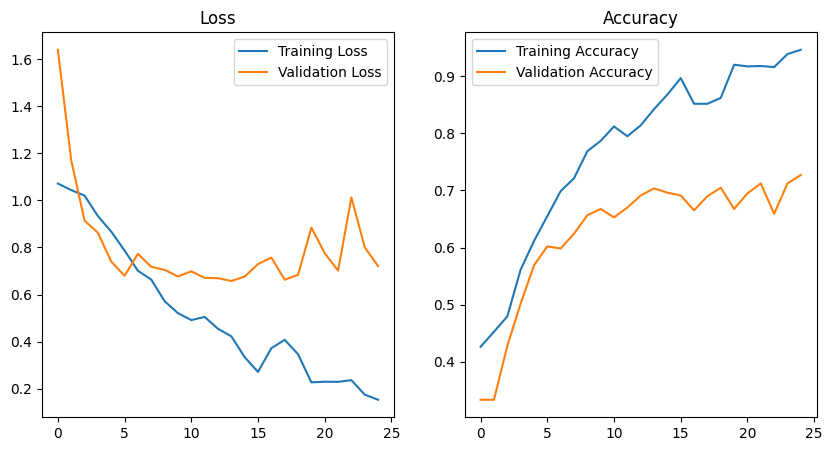

In [16]:
train_accs=torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)  

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()

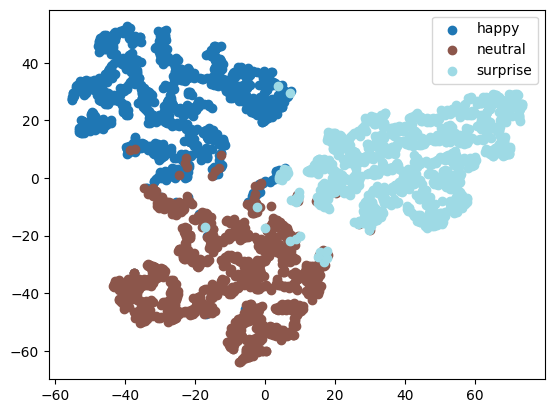

In [17]:
label_names = train_data.class_names
cmap = colormap.get_cmap('tab20',len(label_names))
colors = [cmap(i) for i in range(len(label_names))]
features = []
labels = []

with torch.no_grad():
    for images, target in train_loader:
        images = images.to(device) 
        outputs = best_model(images)
        features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
        labels.append(target.cpu().numpy())
        
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    mask = (labels == label_id).flatten()
    plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()


100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Test Results:
Test Accuracy: 0.7010

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       340
           1       0.65      0.65      0.65       340
           2       0.73      0.77      0.75       340

    accuracy                           0.70      1020
   macro avg       0.70      0.70      0.70      1020
weighted avg       0.70      0.70      0.70      1020



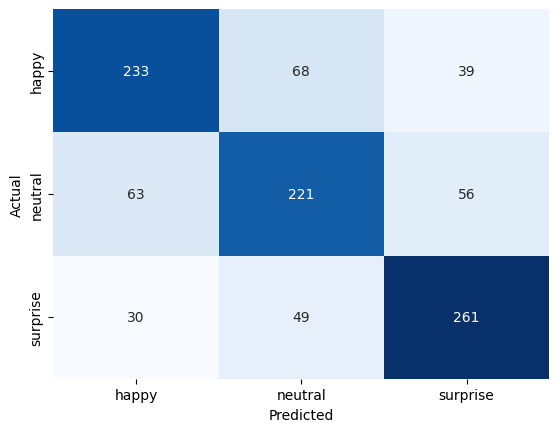

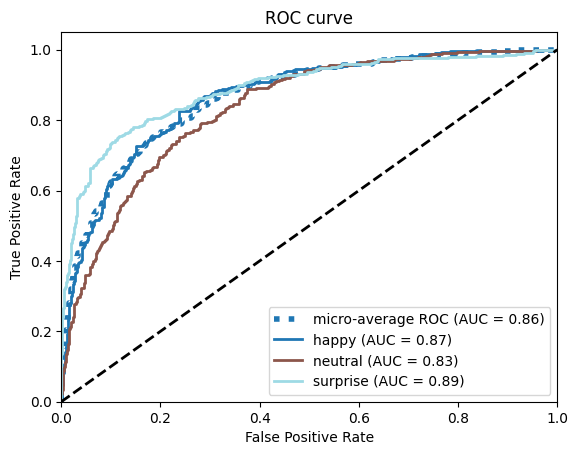

In [18]:
test_model(best_model, test_loader, criterion, device)